In [2]:
# Required Libraries
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Set working directory (adjust based on your environment)
data_path = os.path.abspath(os.getcwd())+'\\'

In [19]:
# Load the NFL spreadspoke data
nfl = pd.read_csv(data_path + "spreadspoke_scores.csv")
nfl = nfl.dropna(subset=['over_under_line'])
nfl['over_under_line'] = pd.to_numeric(nfl['over_under_line'], errors='coerce')

# Convert the schedule_date to a DateTime format
nfl['schedule_date'] = pd.to_datetime(nfl['schedule_date'], format='%m/%d/%Y')

# Load the NFL teams data
teams = pd.read_csv(data_path + "nfl_teams.csv")

# Extract team names and IDs for mapping
team_names = teams['team_name'].values
team_ids = teams['team_id'].values

# Initialize columns for home and away team IDs
nfl['team_home_id'] = np.nan
nfl['team_away_id'] = np.nan

# Mapping team names to team IDs for home and away teams
for i in range(len(nfl)):
    # Mapping for home team
    for j in range(len(team_ids)):
        if nfl.iloc[i]['team_home'] == team_names[j]:
            nfl.loc[nfl.index[i], 'team_home_id'] = team_ids[j]
    
    # Mapping for away team
    for j in range(len(team_ids)):
        if nfl.iloc[i]['team_away'] == team_names[j]:
            nfl.loc[nfl.index[i], 'team_away_id'] = team_ids[j]


# Convert team IDs to categorical types for modeling purposes
nfl['team_home_id'] = nfl['team_home_id'].astype('category')
nfl['team_away_id'] = nfl['team_away_id'].astype('category')

# Generate a unique game ID by combining the schedule date, away team ID, and home team ID
nfl['game_id'] = nfl.apply(lambda row: f"{row['schedule_date'].strftime('%Y%m%d')}_{row['team_away_id']}_{row['team_home_id']}", axis=1)

# Remove hyphens from game ID
nfl['game_id'] = nfl['game_id'].str.replace("-", "")

# Load stadium data and add stadium type to the dataset
stadiums = pd.read_csv(data_path + "nfl_stadiums.csv")
stadiums_dict = dict(zip(stadiums['stadium_name'], stadiums['stadium_type']))

# Assign stadium types to the nfl DataFrame
nfl['stadium_type'] = nfl['stadium'].map(stadiums_dict)

# Add dummy variables for the first and last weeks of the season
nfl['schedule_week_1'] = nfl['schedule_week'] == 1
nfl['schedule_week_last'] = nfl.apply(
    lambda row: row['schedule_week'] == (18 if row['schedule_season'] in [1993, 1999] else 17 if row['schedule_season'] != 1987 else 16),
    axis=1
)

# Add day of the week and month information
nfl['schedule_day'] = nfl['schedule_date'].dt.day_name()
nfl['schedule_month'] = nfl['schedule_date'].dt.month_name()

# Determine if the game was played on a Sunday
nfl['schedule_sunday'] = nfl['schedule_day'] == 'Sunday'

# Mapping divisional information
team_divisions = teams['team_division'].values
nfl['team_home_division'] = nfl['team_home'].map(dict(zip(team_names, team_divisions)))
nfl['team_away_division'] = nfl['team_away'].map(dict(zip(team_names, team_divisions)))

# Pre-2002 division information
team_divisions_pre2002 = teams['team_division_pre2002'].values
nfl['team_home_division_pre2002'] = nfl['team_home'].map(dict(zip(team_names, team_divisions_pre2002)))
nfl['team_away_division_pre2002'] = nfl['team_away'].map(dict(zip(team_names, team_divisions_pre2002)))

# Determine if the game is a divisional matchup
nfl['division_matchup'] = nfl.apply(
    lambda row: row['team_away_division'] == row['team_home_division'] or 
    row['team_away_division_pre2002'] == row['team_home_division_pre2002'], axis=1)

# Spread calculations
nfl['team_home_favorite'] = nfl['team_favorite_id'] == nfl['team_home_id']
nfl['spread_home'] = np.where(nfl['team_home_favorite'], nfl['spread_favorite'], -nfl['spread_favorite'])
nfl['spread_away'] = -nfl['spread_home']

# Categorizing spread types
nfl['spread_type'] = np.where(nfl['spread_home'] == 0, 'Pick',
                             np.where(nfl['spread_home'] > 0, 'Home Underdog', 'Home Favorite'))

# Determining spread outliers
nfl['spread_outlier'] = np.where(abs(nfl['spread_favorite']) > 14.1, '2TD+',
                                np.where(abs(nfl['spread_favorite']) > 10.1, '1TD1FG+',
                                         np.where(abs(nfl['spread_favorite']) > 7.1, '1TD+', 'No Outlier')))
# Categorizing over/under outliers
nfl['over_under_outlier'] = np.where(nfl['over_under_line'] < 33, 'Under 2sd',
                                     np.where(nfl['over_under_line'] < 37, 'Under 1sd',
                                              np.where(nfl['over_under_line'] > 50, 'Over 2sd',
                                                       np.where(nfl['over_under_line'] > 46, 'Over 1sd', 'No Outlier'))))

In [20]:
class Elo:
    WIN = 1.0
    DRAW = 0.5
    LOSS = 0.0
    K_FACTOR = 10
    INITIAL = 1200
    BETA = 200

    def __init__(self, k_factor=K_FACTOR, initial=INITIAL, beta=BETA):
        self.k_factor = k_factor
        self.initial = initial
        self.beta = beta

    def expect(self, rating, other_rating):
        """The 'E' function in Elo. Calculates the expected score of the first rating by the second rating."""
        diff = float(other_rating) - float(rating)
        f_factor = 2 * self.beta  # rating disparity
        return 1.0 / (1 + 10 ** (diff / f_factor))

    def adjust(self, rating, series):
        """Calculates the adjustment value based on a series of matches."""
        return sum(score - self.expect(rating, other_rating) for score, other_rating in series)

    def rate(self, rating, series):
        """Calculates a new rating based on the match results."""
        new_rating = float(rating) + self.k_factor * self.adjust(rating, series)
        return new_rating

    def rate_1vs1(self, rating1, rating2, drawn=False):
        """Calculates the new ratings for a one-on-one match."""
        scores = (self.DRAW, self.DRAW) if drawn else (self.WIN, self.LOSS)
        new_rating1 = self.rate(rating1, [(scores[0], rating2)])
        new_rating2 = self.rate(rating2, [(scores[1], rating1)])
        return new_rating1, new_rating2

elo_system = Elo()

In [21]:
# Determine spread outliers
nfl['spread_outlier'] = np.where(abs(nfl['spread_favorite']) > 14.1, '2TD+',
                                np.where(abs(nfl['spread_favorite']) > 10.1, '1TD1FG+',
                                         np.where(abs(nfl['spread_favorite']) > 7.1, '1TD+', 'No Outlier')))

# Splitting the dataset into historical and forecast data based on date
forecast_cutoff_date = datetime.strptime('2024-12-31', '%Y-%m-%d')
nfl_forecast = nfl[nfl['schedule_date'] > forecast_cutoff_date].copy()  # Data for future games
nfl = nfl[nfl['schedule_date'] <= forecast_cutoff_date].copy()  # Data for past games

# Dictionary to store Elo ratings for each team
elo_ratings = {}
initial_elo = 1000  # Initial Elo rating for new teams

def update_elo(winner, loser, tie=False):
    """
    Update the Elo ratings for the winner and loser.
    If it's a tie, adjust accordingly.
    """
    if tie:
        return elo_system.rate_1vs1(elo_ratings[winner], elo_ratings[loser], drawn=True)
    else:
        return elo_system.rate_1vs1(elo_ratings[winner], elo_ratings[loser])

# Iterate over each row in the DataFrame to update Elo ratings
for index, row in nfl.iterrows():
    home_team = row['team_home_id']
    away_team = row['team_away_id']
    
    # Initialize Elo ratings if teams are not already in the dictionary
    if home_team not in elo_ratings:
        elo_ratings[home_team] = initial_elo
    if away_team not in elo_ratings:
        elo_ratings[away_team] = initial_elo
    
    # Determine the game outcome
    if row['score_home'] > row['score_away']:
        winner, loser = home_team, away_team
        tie = False
    elif row['score_away'] > row['score_home']:
        winner, loser = away_team, home_team
        tie = False
    else:
        # If it's a tie
        winner, loser = home_team, away_team
        tie = True
    
    # Update Elo ratings for the winner and loser
    elo_ratings[winner], elo_ratings[loser] = update_elo(winner, loser, tie)

# Assign pre-game Elo ratings to the DataFrame
nfl['team_home_elo_pre'] = nfl['team_home_id'].apply(lambda x: elo_ratings.get(x, initial_elo))
nfl['team_away_elo_pre'] = nfl['team_away_id'].apply(lambda x: elo_ratings.get(x, initial_elo))

# Ensure Elo ratings are numeric before performing arithmetic operations
nfl['team_home_elo_pre'] = pd.to_numeric(nfl['team_home_elo_pre'], errors='coerce')
nfl['team_away_elo_pre'] = pd.to_numeric(nfl['team_away_elo_pre'], errors='coerce')

# Calculate the difference in pre-game Elo ratings
nfl['elo_pre_difference'] = nfl['team_home_elo_pre'] - nfl['team_away_elo_pre']

# Calculate the probability of the home team winning
def win_probability(home_elo, away_elo):
    """
    Calculate the probability of the home team winning based on Elo ratings.
    Includes a 55 Elo point home-field advantage adjustment.
    """
    return 1 / (1 + 10 ** ((away_elo - home_elo + 55) / 400))

# Apply the win probability function to each row
nfl['team_home_win_prob'] = nfl.apply(lambda row: win_probability(row['team_home_elo_pre'], row['team_away_elo_pre']), axis=1)
nfl['team_away_win_prob'] = 1 - nfl['team_home_win_prob']

nfl['team_home_result'] = nfl.apply(lambda row: 'Win' if row['score_home'] > row['score_away'] else ('Tie' if row['score_home'] == row['score_away'] else 'Loss'), axis=1)
nfl['team_away_result'] = nfl.apply(lambda row: 'Win' if row['score_away'] > row['score_home'] else ('Tie' if row['score_away'] == row['score_home'] else 'Loss'), axis=1)

# Calculate rolling averages and statistics using pandas
nfl = nfl.sort_values(['team_home_id', 'schedule_date'])

# Calculate score totals and win/loss/tie counts
nfl['score_total'] = nfl['score_home'] + nfl['score_away']
nfl['team_home_win_count'] = np.where(nfl['team_home_result'] == 'Win', 1,
                                      np.where(nfl['team_home_result'] == 'Tie', 0.5, 0))
nfl['team_away_win_count'] = np.where(nfl['team_away_result'] == 'Win', 1,
                                      np.where(nfl['team_home_result'] == 'Tie', 0.5, 0))

nfl.tail()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,team_home_elo_pre,team_away_elo_pre,elo_pre_difference,team_home_win_prob,team_away_win_prob,team_home_result,team_away_result,score_total,team_home_win_count,team_away_win_count
13678,2023-11-19,2023,11,False,Washington Commanders,19.0,31.0,New York Giants,WAS,-8.5,...,911.798813,916.508596,-4.709784,0.414907,0.585093,Loss,Win,50.0,0.0,1.0
13707,2023-12-03,2023,13,False,Washington Commanders,15.0,45.0,Miami Dolphins,MIA,-9.0,...,911.798813,1016.187970,-104.389157,0.285464,0.714536,Loss,Win,60.0,0.0,1.0
13771,2023-12-31,2023,17,False,Washington Commanders,10.0,27.0,San Francisco 49ers,SF,-14.0,...,911.798813,1076.553827,-164.755014,0.220112,0.779888,Loss,Win,37.0,0.0,1.0
13787,2024-01-07,2023,18,False,Washington Commanders,10.0,38.0,Dallas Cowboys,DAL,-13.0,...,911.798813,1065.469587,-153.670774,0.231261,0.768739,Loss,Win,48.0,0.0,1.0
13831,2024-09-15,2024,2,False,Washington Commanders,21.0,18.0,New York Giants,WAS,-1.5,...,911.798813,916.508596,-4.709784,0.414907,0.585093,Win,Loss,39.0,1.0,0.0


In [22]:
# Over/Under Analysis
nfl['over_under_result'] = np.where(nfl['score_total'] == nfl['over_under_line'], 'Push',
                                    np.where(nfl['score_total'] > nfl['over_under_line'], 'Over', 'Under'))
nfl['over_under_result_count'] = np.where(nfl['over_under_result'] == 'Push', 0.5,
                                          np.where(nfl['over_under_result'] == 'Over', 1, 0))

# Spread Analysis
nfl['spread_home_result'] = nfl['score_away'] - nfl['score_home']
nfl['spread_away_result'] = nfl['score_home'] - nfl['score_away']

# Favorite score calculations
nfl['score_favorite'] = np.where(nfl['team_favorite_id'] == nfl['team_home_id'], nfl['score_home'], nfl['score_away'])
nfl['score_underdog'] = np.where(nfl['team_favorite_id'] == nfl['team_home_id'], nfl['score_away'], nfl['score_home'])

# Spread cover results
nfl['spread_favorite_result'] = np.where(nfl['team_favorite_id'] == nfl['team_home_id'], nfl['spread_home_result'], nfl['spread_away_result'])
nfl['spread_favorite_cover_result'] = np.where(nfl['spread_favorite_result'] == 0, 'Push',
                                               np.where((nfl['score_favorite'] + nfl['spread_favorite']) > nfl['score_underdog'], 'Cover', 'Did Not Cover'))
nfl['spread_favorite_cover_count'] = np.where(nfl['spread_favorite_cover_result'] == 'Push', 0.5,
                                              np.where(nfl['spread_favorite_cover_result'] == 'Cover', 1, 0))
nfl['spread_underdog_cover_result'] = np.where(nfl['spread_favorite_cover_result'] == 'Push', 'Push',
                                               np.where(nfl['spread_favorite_cover_result'] == 'Cover', 'Did Not Cover', 'Cover'))
nfl['spread_underdog_cover_count'] = np.where(nfl['spread_underdog_cover_result'] == 'Push', 0.5,
                                              np.where(nfl['spread_underdog_cover_result'] == 'Cover', 1, 0))

# Home and away spread cover results
nfl['spread_home_cover_result'] = np.where(nfl['team_home_favorite'], nfl['spread_favorite_cover_result'], nfl['spread_underdog_cover_result'])
nfl['spread_home_cover_count'] = np.where(nfl['spread_home_cover_result'] == 'Push', 0.5,
                                          np.where(nfl['spread_home_cover_result'] == 'Cover', 1, 0))
nfl['spread_away_cover_result'] = np.where(nfl['team_home_favorite'], nfl['spread_underdog_cover_result'], nfl['spread_favorite_cover_result'])
nfl['spread_away_cover_count'] = np.where(nfl['spread_away_cover_result'] == 'Push', 0.5,
                                          np.where(nfl['spread_away_cover_result'] == 'Cover', 1, 0))

nfl.tail()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,score_underdog,spread_favorite_result,spread_favorite_cover_result,spread_favorite_cover_count,spread_underdog_cover_result,spread_underdog_cover_count,spread_home_cover_result,spread_home_cover_count,spread_away_cover_result,spread_away_cover_count
13678,2023-11-19,2023,11,False,Washington Commanders,19.0,31.0,New York Giants,WAS,-8.5,...,31.0,12.0,Did Not Cover,0.0,Cover,1.0,Did Not Cover,0.0,Cover,1.0
13707,2023-12-03,2023,13,False,Washington Commanders,15.0,45.0,Miami Dolphins,MIA,-9.0,...,15.0,-30.0,Cover,1.0,Did Not Cover,0.0,Did Not Cover,0.0,Cover,1.0
13771,2023-12-31,2023,17,False,Washington Commanders,10.0,27.0,San Francisco 49ers,SF,-14.0,...,10.0,-17.0,Cover,1.0,Did Not Cover,0.0,Did Not Cover,0.0,Cover,1.0
13787,2024-01-07,2023,18,False,Washington Commanders,10.0,38.0,Dallas Cowboys,DAL,-13.0,...,10.0,-28.0,Cover,1.0,Did Not Cover,0.0,Did Not Cover,0.0,Cover,1.0
13831,2024-09-15,2024,2,False,Washington Commanders,21.0,18.0,New York Giants,WAS,-1.5,...,18.0,-3.0,Cover,1.0,Did Not Cover,0.0,Cover,1.0,Did Not Cover,0.0


In [23]:
# Prepare nflCalc for merging both home and away game data
home_games = pd.DataFrame({
    'game_id': nfl['game_id'],
    'season': nfl['schedule_season'],
    'schedule_week': nfl['schedule_week'],
    'team': nfl['team_home_id'],
    'opponent': nfl['team_away_id'],
    'schedule_date': nfl['schedule_date'],
    'venue': 'home',
    'score': nfl['score_home'],
    'score_against': nfl['score_away'],
    'score_margin': nfl['score_home'] - nfl['score_away'],
    'spread': nfl['spread_home'],
    'overunder': nfl['over_under_line'],
    'elo': nfl['team_home_elo_pre'],
    'win_count': nfl['team_home_win_count'],
    'cover_count': nfl['spread_home_cover_count'],
    'over_count': nfl['over_under_result_count'],
    'game_count': 1,
    'duplicate': False
})

away_games = pd.DataFrame({
    'game_id': nfl['game_id'],
    'season': nfl['schedule_season'],
    'schedule_week': nfl['schedule_week'],
    'team': nfl['team_away_id'],
    'opponent': nfl['team_home_id'],
    'schedule_date': nfl['schedule_date'],
    'venue': 'away',
    'score': nfl['score_away'],
    'score_against': nfl['score_home'],
    'score_margin': nfl['score_away'] - nfl['score_home'],
    'spread': nfl['spread_away'],
    'overunder': nfl['over_under_line'],
    'elo': nfl['team_away_elo_pre'],
    'win_count': nfl['team_away_win_count'],
    'cover_count': nfl['spread_away_cover_count'],
    'over_count': nfl['over_under_result_count'],
    'game_count': 1,
    'duplicate': True
})

# Combine the home and away games into a single DataFrame
nflCalc = pd.concat([home_games, away_games], ignore_index=True)

# Sort the combined DataFrame by schedule date
nflCalc = nflCalc.sort_values(by='schedule_date').reset_index(drop=True)

nflCalc.head(11)

,game_id,season,schedule_week,team,opponent,schedule_date,venue,score,score_against,score_margin,spread,overunder,elo,win_count,cover_count,over_count,game_count,duplicate
0,19680114_LVR_GB,1967,Superbowl,LVR,GB,1968-01-14,away,14.0,33.0,-19.0,13.5,43.0,963.583457,0.0,0.0,1.0,1,True
1,19680114_LVR_GB,1967,Superbowl,GB,LVR,1968-01-14,home,33.0,14.0,19.0,-13.5,43.0,1068.799264,1.0,1.0,1.0,1,False
2,19690112_NYJ_IND,1968,Superbowl,IND,NYJ,1969-01-12,home,7.0,16.0,-9.0,-18.0,40.0,974.019557,0.0,0.0,0.0,1,False
3,19690112_NYJ_IND,1968,Superbowl,NYJ,IND,1969-01-12,away,16.0,7.0,9.0,18.0,40.0,905.151525,1.0,1.0,0.0,1,True
4,19700111_MIN_KC,1969,Superbowl,KC,MIN,1970-01-11,home,23.0,7.0,16.0,12.0,39.0,1177.089661,1.0,1.0,0.0,1,False
5,19700111_MIN_KC,1969,Superbowl,MIN,KC,1970-01-11,away,7.0,23.0,-16.0,-12.0,39.0,1033.313466,0.0,0.0,0.0,1,True
6,19710117_DAL_IND,1970,Superbowl,DAL,IND,1971-01-17,away,13.0,16.0,-3.0,2.5,36.0,1065.469587,0.0,0.0,0.0,1,True
7,19710117_DAL_IND,1970,Superbowl,IND,DAL,1971-01-17,home,16.0,13.0,3.0,-2.5,36.0,974.019557,1.0,1.0,0.0,1,False
8,19720116_MIA_DAL,1971,Superbowl,MIA,DAL,1972-01-16,away,3.0,24.0,-21.0,6.0,34.0,1016.187970,0.0,0.0,0.0,1,True
9,19720116_MIA_DAL,1971,Superbowl,DAL,MIA,1972-01-16,home,24.0,3.0,21.0,-6.0,34.0,1065.469587,1.0,1.0,0.0,1,False


In [24]:
# Set the number of games for the rolling calculations (k = 16 for last 16 games)
k = 6

# Group by team and perform various cumulative and rolling calculations
nflCalc = nflCalc.sort_values(by=['team', 'schedule_date']).groupby('team').apply(lambda df: (
    df.assign(
        # Days since last game (bye week calculations)
        days_since_last_game=lambda x: x['schedule_date'].diff().dt.days,
        
        # Cumulative win percentage (all games)
        win_pct=lambda x: x['win_count'].cumsum() / x['game_count'].cumsum(),
        
        # Rolling win percentage for the last `k` games
        win_pct_roll=lambda x: x['win_count'].rolling(window=k, min_periods=1).mean(),
        
        # Cover percentage calculation
        cover_pct=lambda x: x['cover_count'].cumsum() / x['game_count'].cumsum(),
        
        # Rolling cover percentage for the last `k` games
        cover_pct_roll=lambda x: x['cover_count'].rolling(window=k, min_periods=1).mean(),
        
        # Over percentage calculation
        over_pct=lambda x: x['over_count'].cumsum() / x['game_count'].cumsum(),
        
        # Rolling over percentage for the last `k` games
        over_pct_roll=lambda x: x['over_count'].rolling(window=k, min_periods=1).mean(),
        
        # Cumulative average points scored (for)
        score_avg_pts_for=lambda x: x['score'].expanding().mean(),
        
        # Rolling average points scored over the last `k` games (for)
        score_avg_pts_for_roll=lambda x: x['score'].rolling(window=k, min_periods=1).mean(),
        
        # Cumulative average points allowed (against)
        score_avg_pts_against=lambda x: x['score_against'].expanding().mean(),
        
        # Rolling average points allowed over the last `k` games (against)
        score_avg_pts_against_roll=lambda x: x['score_against'].rolling(window=k, min_periods=1).mean()
    )
)).reset_index(drop=True)

# Now, perform similar calculations but group by both team and season
nflCalc = nflCalc.groupby(['team', 'season']).apply(lambda df: (
    df.assign(
        # Cumulative wins, losses, and ties for the season
        wins_roll_season=lambda x: (x['win_count'] == 1).cumsum(),
        losses_roll_season=lambda x: ((x['win_count'] == 0) & (x['win_count'] != 0.5)).cumsum(),
        ties_roll_season=lambda x: (x['win_count'] == 0.5).cumsum(),
        
        # Season win percentage
        win_pct_roll_season=lambda x: x['win_count'].cumsum() / x['game_count'].cumsum(),
        
        # Season cover percentage
        cover_pct_roll_season=lambda x: x['cover_count'].cumsum() / x['game_count'].cumsum(),
        
        # Season over percentage
        over_pct_roll_season=lambda x: x['over_count'].cumsum() / x['game_count'].cumsum(),
        
        # Cumulative average points scored for the season
        score_avg_pts_for_roll_season=lambda x: x['score'].expanding().mean(),
        
        # Cumulative average points allowed for the season
        score_avg_pts_against_roll_season=lambda x: x['score_against'].expanding().mean()
    )
)).reset_index(drop=True)

# Team offense and defense classification
# Teams scoring more than 24 points per game are classified as 'strong' offense,
# less than 18 as 'weak', otherwise as 'neutral'
nflCalc['team_offense_type'] = np.where(nflCalc['score_avg_pts_for_roll'].isna(), 'neutral',
                                        np.where(nflCalc['score_avg_pts_for_roll'] > 24, 'strong',
                                                 np.where(nflCalc['score_avg_pts_for_roll'] < 18, 'weak', 'neutral')))

# Teams allowing more than 24 points per game are classified as 'weak' defense,
# less than 18 as 'strong', otherwise as 'neutral'
nflCalc['team_defense_type'] = np.where(nflCalc['score_avg_pts_against_roll'].isna(), 'neutral',
                                        np.where(nflCalc['score_avg_pts_against_roll'] > 24, 'weak',
                                                 np.where(nflCalc['score_avg_pts_against_roll'] < 18, 'strong', 'neutral')))

# Create the team statistics table
teamTable = (
    nflCalc.groupby(['team', 'season'])
    .agg(
        wins_roll_season=('wins_roll_season', 'last'),
        losses_roll_season=('losses_roll_season', 'last'),
        ties_roll_season=('ties_roll_season', 'last'),
        win_pct_roll_season=('win_pct_roll_season', 'last'),
        cover_pct_roll_season=('cover_pct_roll_season', 'last'),
        over_pct_roll_season=('over_pct_roll_season', 'last'),
        score_avg_pts_for_roll_season=('score_avg_pts_for_roll_season', 'last'),
        score_avg_pts_against_roll_season=('score_avg_pts_against_roll_season', 'last'),
        score_total_pts_for_roll_season=('score', 'sum'),
        score_total_pts_against_roll_season=('score_against', 'sum')
    )
    .reset_index()
)

# Round percentage values to one decimal place
teamTable['win_pct_roll_season'] = (teamTable['win_pct_roll_season'] * 100).round(1)
teamTable['cover_pct_roll_season'] = (teamTable['cover_pct_roll_season'] * 100).round(1)
teamTable['over_pct_roll_season'] = (teamTable['over_pct_roll_season'] * 100).round(1)
teamTable['score_avg_pts_for_roll_season'] = teamTable['score_avg_pts_for_roll_season'].round(1)
teamTable['score_avg_pts_against_roll_season'] = teamTable['score_avg_pts_against_roll_season'].round(1)

# Filter the table to only include seasons after 2017
teamTable = teamTable[teamTable['season'] > 2015]

# Rename the columns for the final output
teamTable.columns = ['Team', 'Season', 'W', 'L', 'T', 'Win %', 'Cover %', 'Over %', 'Off Pts/G', 'Def Pts/G', 'Off Tot Pts', 'Def Tot Pts']

# Save the final table as a CSV
teamTable.sort_values(by=['Season', 'Win %'], ascending=[False, False], inplace=True)
teamTable.to_csv("teams.csv", index=False)

C:\Users\harsh\AppData\Local\Temp\ipykernel_44844\1663415316.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  nflCalc = nflCalc.sort_values(by=['team', 'schedule_date']).groupby('team').apply(lambda df: (
C:\Users\harsh\AppData\Local\Temp\ipykernel_44844\1663415316.py:43: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupb

In [25]:
# Step 1: Forecast Elo Ratings
# Get the most recent Elo rating for each team for forecasting
eloForecast = (
    nflCalc.groupby('team')
    .apply(lambda df: df.loc[df['schedule_date'].idxmax()])
    .reset_index(drop=True)
    [['team', 'elo']]
)

# Step 2: Team Offense/Defense Stats for Forecasting
# Get the most recent offensive and defensive statistics for each team
teamPointsForecast = (
    nflCalc.groupby('team')
    .apply(lambda df: df.loc[df['schedule_date'].idxmax()])
    .reset_index(drop=True)
    [['team', 'score_avg_pts_for_roll', 'score_avg_pts_against_roll', 'team_offense_type', 'team_defense_type']]
)

# Step 3: Calculating Bye Weeks
# Calculate days since last game to identify bye weeks or short weeks
teamByeWeeks = (
    nflCalc.groupby('team')
    .apply(lambda df: df.assign(days_since_last_game=df['schedule_date'].diff().dt.days))
    .reset_index(drop=True)
    [['schedule_date', 'team', 'opponent', 'game_id', 'days_since_last_game']]
)

# Assign bye week, short week, or normal based on days since last game
teamByeWeeks['schedule_bye'] = np.where(
    (teamByeWeeks['days_since_last_game'] > 13) & (teamByeWeeks['days_since_last_game'] < 21), 'Bye Week',
    np.where(teamByeWeeks['days_since_last_game'] < 6, 'Short Week', 'Normal')
)

# Step 4: Select Variables Needed for Forecasting
nflCalc = nflCalc[[
    'game_id', 'schedule_date', 'season', 'schedule_week', 'team', 'opponent', 'venue', 'elo',
    'score_avg_pts_for_roll', 'score_avg_pts_against_roll', 'team_offense_type', 'team_defense_type'
]]

# Split data into home and away datasets
nflHome = nflCalc[nflCalc['venue'] == 'home']
nflAway = nflCalc[nflCalc['venue'] == 'away']

# Merge home and away data to create a game-level dataset
nflTemp = pd.merge(
    nflHome, nflAway,
    on=['game_id', 'schedule_date', 'season', 'schedule_week'],
    suffixes=('.home', '.away')
)

# Select relevant columns from the merged data
nflTemp = nflTemp[[
    'game_id', 'schedule_date', 'score_avg_pts_for_roll.home', 'score_avg_pts_against_roll.home',
    'score_avg_pts_for_roll.away', 'score_avg_pts_against_roll.away', 'team_offense_type.home',
    'team_defense_type.home', 'team_offense_type.away', 'team_defense_type.away'
]]

# Merge the temporary dataset back into the original nfl DataFrame
nfl = pd.merge(nfl, nflTemp, on=['game_id', 'schedule_date'])

# Step 5: Weather Variables
# Assign weather-related variables based on conditions in the game data
nfl['weather_cold'] = np.where(nfl['weather_temperature'].isna(), False, nfl['weather_temperature'] < 36)
nfl['weather_wind_bad'] = np.where(nfl['weather_wind_mph'].isna(), False, nfl['weather_wind_mph'] > 12)
nfl['weather_rain'] = nfl['weather_detail'].str.contains('Rain', case=False, na=False)
nfl['weather_snow'] = nfl['weather_detail'].str.contains('Snow', case=False, na=False)
nfl['weather_fog'] = nfl['weather_detail'].str.contains('Fog', case=False, na=False)

# Step 6: Convert Certain Columns to Categorical
nfl['team_offense_type.home'] = nfl['team_offense_type.home'].astype('category')
nfl['team_defense_type.home'] = nfl['team_defense_type.home'].astype('category')
nfl['team_offense_type.away'] = nfl['team_offense_type.away'].astype('category')
nfl['team_defense_type.away'] = nfl['team_defense_type.away'].astype('category')
nfl['spread_favorite_cover_result'] = nfl['spread_favorite_cover_result'].astype('category')
nfl['spread_underdog_cover_result'] = nfl['spread_underdog_cover_result'].astype('category')

nfl.head()

C:\Users\harsh\AppData\Local\Temp\ipykernel_44844\621058880.py:23: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda df: df.assign(days_since_last_game=df['schedule_date'].diff().dt.days))


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,score_avg_pts_against_roll.away,team_offense_type.home,team_defense_type.home,team_offense_type.away,team_defense_type.away,weather_cold,weather_wind_bad,weather_rain,weather_snow,weather_fog
0,1979-09-02,1979,1,False,St. Louis Cardinals,21.0,22.0,Dallas Cowboys,DAL,-4.0,...,17.666667,neutral,neutral,neutral,strong,False,False,False,False,False
1,1979-09-16,1979,3,False,St. Louis Cardinals,21.0,24.0,Pittsburgh Steelers,PIT,-6.0,...,15.833333,neutral,neutral,strong,strong,False,False,False,False,False
2,1979-09-23,1979,4,False,St. Louis Cardinals,7.0,17.0,Washington Redskins,ARI,-3.0,...,14.800000,neutral,neutral,neutral,strong,False,False,False,False,False
3,1979-10-14,1979,7,False,St. Louis Cardinals,20.0,24.0,Philadelphia Eagles,ARI,-3.0,...,15.333333,weak,neutral,neutral,strong,False,False,False,False,False
4,1979-10-28,1979,9,False,St. Louis Cardinals,20.0,38.0,Cleveland Browns,ARI,-3.0,...,24.833333,weak,neutral,strong,weak,False,False,False,False,False


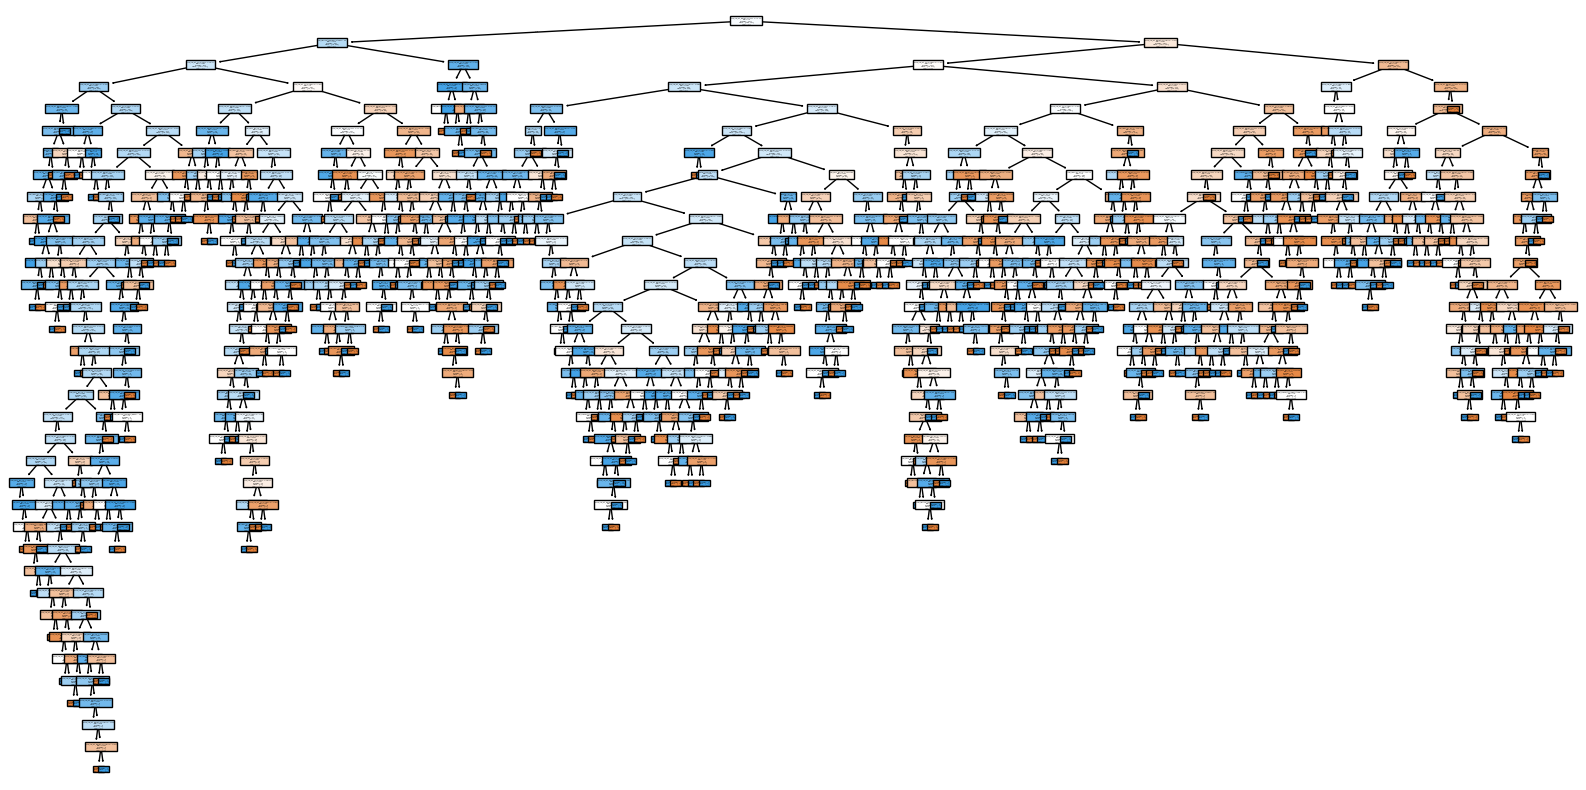

Over/Under Classification Report:
              precision    recall  f1-score   support

        Over       0.49      0.51      0.50       396
       Under       0.58      0.56      0.57       479

    accuracy                           0.54       875
   macro avg       0.54      0.54      0.54       875
weighted avg       0.54      0.54      0.54       875

Confusion Matrix:
[[202 194]
 [209 270]]


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

# Split the dataset into training and testing sets
train = nfl[(nfl['schedule_season'] > 2010) & (nfl['schedule_season'] <= 2020)]
test = nfl[nfl['schedule_season'] > 2020]

# Remove rows where the over_under_result is "Push" from both training and testing datasets
train = train[train['over_under_result'].isin(['Over', 'Under'])]
test = test[test['over_under_result'].isin(['Over', 'Under'])]

# Step 1: Classification for Over/Under Prediction
# Define the basic features (excluding one-hot encoded columns)
basic_features_over = [
    'team_home_elo_pre', 'team_away_elo_pre',
    'score_avg_pts_for_roll.home', 'score_avg_pts_against_roll.home',
    'score_avg_pts_for_roll.away', 'score_avg_pts_against_roll.away',
    'weather_cold', 'weather_wind_bad', 'weather_rain', 'weather_snow', 'weather_fog'
]

# Handle categorical encoding: One-hot encode offense and defense types
categorical_cols = ['team_offense_type.home', 'team_defense_type.home', 
                    'team_offense_type.away', 'team_defense_type.away']

# Perform one-hot encoding on categorical columns
train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
test = pd.get_dummies(test, columns=categorical_cols, drop_first=True)

# Dynamically add one-hot encoded columns to the feature list
encoded_features_over = [col for col in train.columns if any(prefix in col for prefix in categorical_cols)]
features_over = basic_features_over + encoded_features_over

# Ensure the test data has the same columns as the training data after encoding
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0
test = test[train.columns]  # Ensure the same column order

# Decision tree classifier for over/under prediction
over_model = DecisionTreeClassifier()
over_model.fit(train[features_over], train['over_under_result'])

# Plotting the decision tree
plt.figure(figsize=(20, 10))
plot_tree(over_model, feature_names=features_over, class_names=['Under', 'Over'], filled=True)
plt.show()

# Predict and evaluate the over/under model
over_predictions = over_model.predict(test[features_over])
print("Over/Under Classification Report:")
print(classification_report(test['over_under_result'], over_predictions))
print("Confusion Matrix:")
print(confusion_matrix(test['over_under_result'], over_predictions))

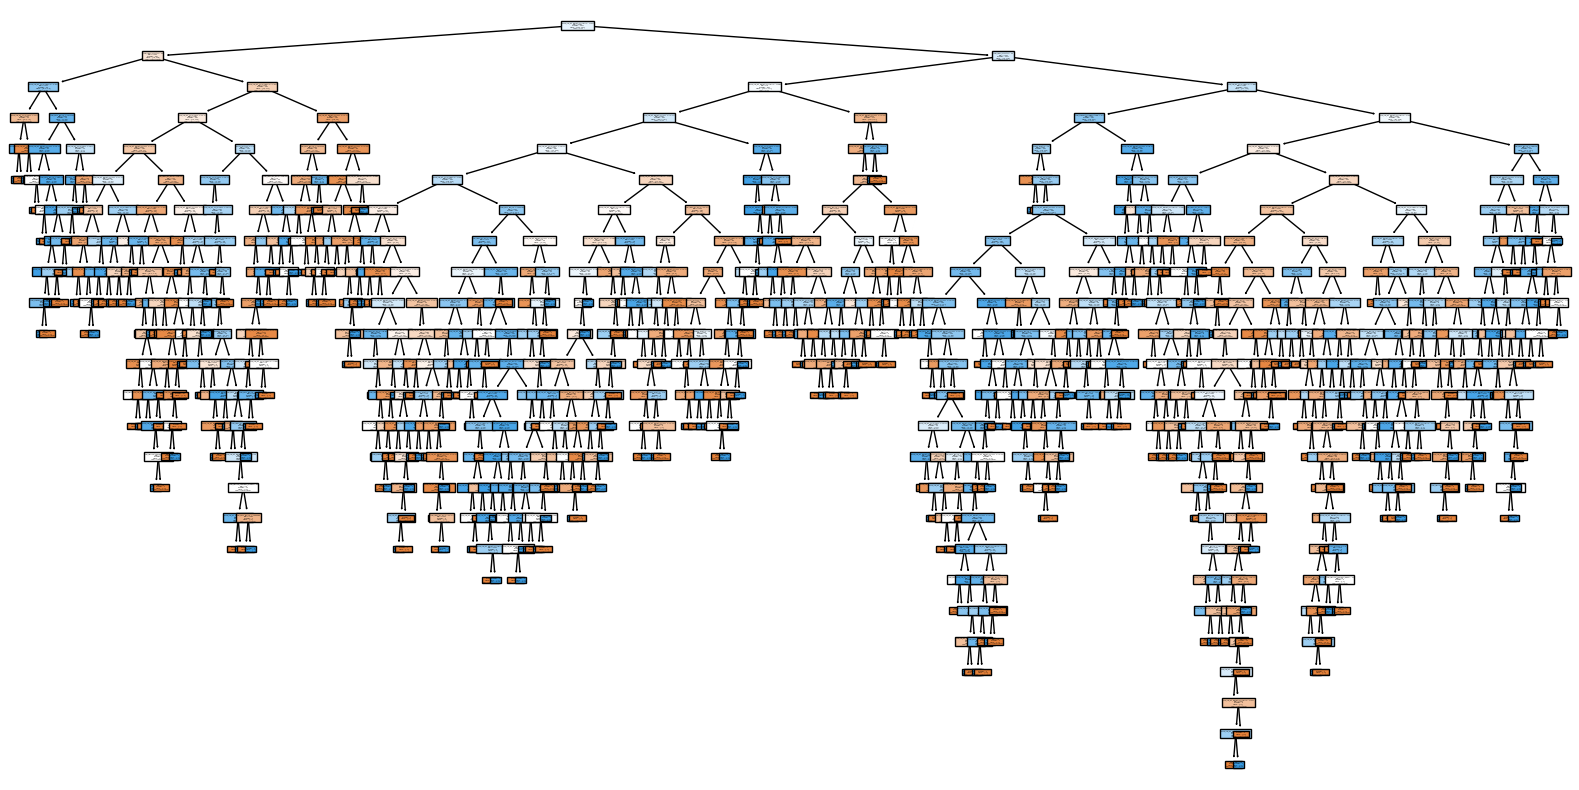

Spread Classification Report:
               precision    recall  f1-score   support

        Cover       0.54      0.55      0.54       412
Did Not Cover       0.59      0.58      0.58       460

     accuracy                           0.56       872
    macro avg       0.56      0.56      0.56       872
 weighted avg       0.56      0.56      0.56       872

Confusion Matrix:
[[226 186]
 [195 265]]


In [27]:
# Step 2: Classification for Spread Prediction
# Remove rows where the spread_favorite_cover_result is "Push" from both training and testing datasets
train = train[train['spread_favorite_cover_result'].isin(['Cover', 'Did Not Cover'])]
test = test[test['spread_favorite_cover_result'].isin(['Cover', 'Did Not Cover'])]

# Mapping month names to numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 
    'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
    'November': 11, 'December': 12
}

# Apply the mapping to the schedule_month column
train['schedule_month'] = train['schedule_month'].map(month_mapping)
test['schedule_month'] = test['schedule_month'].map(month_mapping)

# Define the basic features for spread classification
basic_features_spread = [
    'division_matchup', 'team_home_favorite', 'schedule_week_1', 'schedule_sunday', 'schedule_month',
    'team_home_elo_pre', 'team_away_elo_pre',
    'score_avg_pts_for_roll.home', 'score_avg_pts_against_roll.home',
    'score_avg_pts_for_roll.away', 'score_avg_pts_against_roll.away',
    'weather_cold', 'weather_wind_bad', 'weather_rain', 'weather_snow', 'weather_fog'
]

# Dynamically add one-hot encoded columns to the spread feature list
encoded_features_spread = [col for col in train.columns if any(prefix in col for prefix in categorical_cols)]
features_spread = basic_features_spread + encoded_features_spread

# Decision tree classifier for spread prediction
spread_model = DecisionTreeClassifier()
spread_model.fit(train[features_spread], train['spread_favorite_cover_result'])

# Plotting the decision tree
plt.figure(figsize=(20, 10))
plot_tree(spread_model, feature_names=features_spread, class_names=['Did Not Cover', 'Cover'], filled=True)
plt.show()

# Predict and evaluate the spread model
spread_predictions = spread_model.predict(test[features_spread])
print("Spread Classification Report:")
print(classification_report(test['spread_favorite_cover_result'], spread_predictions))
print("Confusion Matrix:")
print(confusion_matrix(test['spread_favorite_cover_result'], spread_predictions))

In [28]:
# Step 3: Linear Regression for Spread Prediction
# Define the basic features for linear regression
basic_features_regression = [
    'schedule_week_last', 'division_matchup',
    'team_home_elo_pre', 'team_away_elo_pre',
    'team_home_favorite', 'weather_wind_bad', 'weather_cold', 'weather_rain'
]

# Dynamically add one-hot encoded columns to the regression feature list
encoded_features_regression = [col for col in train.columns if any(prefix in col for prefix in categorical_cols)]
features_regression = basic_features_regression + encoded_features_regression

# Train linear regression model
regression_model = LinearRegression()
regression_model.fit(train[features_regression], train['spread_home_result'])

# Display regression coefficients
coefficients = pd.DataFrame({'Feature': features_regression, 'Coefficient': regression_model.coef_})
print("Linear Regression Coefficients:")
print(coefficients)

# Predict using the regression model
spread_home_predictions = regression_model.predict(test[features_regression])

# Display the summary statistics for the linear regression
from sklearn.metrics import root_mean_squared_error, r2_score

mse = root_mean_squared_error(test['spread_home_result'], spread_home_predictions)
r2 = r2_score(test['spread_home_result'], spread_home_predictions)

print(f"Root Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Linear Regression Coefficients:
                          Feature  Coefficient
0              schedule_week_last     0.000000
1                division_matchup    -0.117485
2               team_home_elo_pre    -0.007889
3               team_away_elo_pre     0.006955
4              team_home_favorite     0.238424
5                weather_wind_bad    -0.689841
6                    weather_cold    -1.477526
7                    weather_rain    -0.760473
8   team_offense_type.home_strong    -6.901545
9     team_offense_type.home_weak     5.288768
10  team_defense_type.home_strong    -4.468314
11    team_defense_type.home_weak     6.063640
12  team_offense_type.away_strong     6.904601
13    team_offense_type.away_weak    -3.963086
14  team_defense_type.away_strong     3.887483
15    team_defense_type.away_weak    -5.072426
Root Mean Squared Error: 11.210917265365074
R-squared: 0.3648343799041306


In [3]:
df_game_data = pd.read_csv('nfl_team_stats_2002-2023.csv')

#print(df_game_data.head())
print(df_game_data.columns)

Index(['season', 'week', 'date', 'time_et', 'neutral', 'away', 'home',
       'score_away', 'score_home', 'first_downs_away', 'first_downs_home',
       'first_downs_from_passing_away', 'first_downs_from_passing_home',
       'first_downs_from_rushing_away', 'first_downs_from_rushing_home',
       'first_downs_from_penalty_away', 'first_downs_from_penalty_home',
       'third_down_comp_away', 'third_down_att_away', 'third_down_comp_home',
       'third_down_att_home', 'fourth_down_comp_away', 'fourth_down_att_away',
       'fourth_down_comp_home', 'fourth_down_att_home', 'plays_away',
       'plays_home', 'drives_away', 'drives_home', 'yards_away', 'yards_home',
       'pass_comp_away', 'pass_att_away', 'pass_yards_away', 'pass_comp_home',
       'pass_att_home', 'pass_yards_home', 'sacks_num_away',
       'sacks_yards_away', 'sacks_num_home', 'sacks_yards_home',
       'rush_att_away', 'rush_yards_away', 'rush_att_home', 'rush_yards_home',
       'pen_num_away', 'pen_yards_away', 'pen

In [4]:
# Define home and away columns
home_columns = ['season', 'week', 'date', 'time_et', 'neutral', 'home', 
                'score_home', 'first_downs_home', 'first_downs_from_passing_home',
                'first_downs_from_rushing_home', 'first_downs_from_penalty_home',
                'third_down_comp_home', 'third_down_att_home',
                'fourth_down_comp_home', 'fourth_down_att_home', 'plays_home',
                'drives_home', 'yards_home', 'pass_comp_home', 'pass_att_home',
                'pass_yards_home', 'sacks_num_home', 'sacks_yards_home',
                'rush_att_home', 'rush_yards_home', 'pen_num_home',
                'pen_yards_home', 'redzone_comp_home', 'redzone_att_home',
                'fumbles_home', 'interceptions_home', 'def_st_td_home',
                'possession_home']

away_columns = ['season', 'week', 'date', 'time_et', 'neutral', 'away', 
                'score_away', 'first_downs_away', 'first_downs_from_passing_away',
                'first_downs_from_rushing_away', 'first_downs_from_penalty_away',
                'third_down_comp_away', 'third_down_att_away',
                'fourth_down_comp_away', 'fourth_down_att_away', 'plays_away',
                'drives_away', 'yards_away', 'pass_comp_away', 'pass_att_away',
                'pass_yards_away', 'sacks_num_away', 'sacks_yards_away',
                'rush_att_away', 'rush_yards_away', 'pen_num_away',
                'pen_yards_away', 'redzone_comp_away', 'redzone_att_away',
                'fumbles_away', 'interceptions_away', 'def_st_td_away',
                'possession_away']

# Create separate DataFrames for home and away teams
df_home = df_game_data[home_columns].copy()
df_away = df_game_data[away_columns].copy()

# Display the first few rows of each DataFrame
print("Home Team DataFrame:")
print(df_home.head())

print("\nAway Team DataFrame:")
print(df_away.head())


Home Team DataFrame:
   season week        date  time_et  neutral        home  score_home  \
0    2002    1  2002-09-05  8:30 PM    False      Giants          13   
1    2002    1  2002-09-08  1:00 PM    False     Jaguars          25   
2    2002    1  2002-09-08  1:00 PM    False  Commanders          31   
3    2002    1  2002-09-08  1:00 PM    False    Dolphins          49   
4    2002    1  2002-09-08  1:00 PM    False      Titans          27   

   first_downs_home  first_downs_from_passing_home  \
0                21                             17   
1                19                             11   
2                21                             13   
3                27                             15   
4                22                             15   

   first_downs_from_rushing_home  ...  rush_att_home  rush_yards_home  \
0                              2  ...             22               43   
1                              8  ...             32              118   
2 